In [157]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math

from collections import Counter
# =============================================================================
# 1. CÀI ĐẶT BÀI TOÁN VÀ DỮ LIỆU 
# =============================================================================

# Các tham số chính của bài toán
NUM_BASIC_AREAS = 50  # |B| - Số khu vực cơ bản
MAP_SIZE = 26  # Kích thước bản đồ (100m)

# =============================================================================
# DEPOT - KHO HÀNG
# =============================================================================
DEPOT = {'x': 13, 'y': 13}  # Tọa độ kho hàng ở trung tâm

# =============================================================================
# THÔNG SỐ VẬN HÀNH (Operational Parameters)
# =============================================================================
TRAVEL_SPEED = 500  #- Tốc độ di chuyển trung bình
RELOAD_TIME = 0.25  #  t_reload: Thời gian nạp lại hàng tại depot
T_MAX = 8.0  #  Thời gian làm việc tối đa của tài xế full-time

# =============================================================================
# DRIVER TYPES - D = {1, ..., |D|}
# =============================================================================
DRIVER_TYPES = [
    {
        'id': 1,
        'name': 'Full-time',
        'r_d': 1.0,      # Phần trăm thời gian làm việc (100% = full-time)
        'M_d': 2,        # Số lượng tài xế loại này
        'work_time': T_MAX * 1.0  # 8.0 giờ
    },
    {
        'id': 2,
        'name': 'Part-time (75%)',
        'r_d': 0.75,     # 75% thời gian full-time
        'M_d': 0,        # Số lượng tài xế loại này
        'work_time': T_MAX * 0.75  # 6.0 giờ
    },
    {
        'id': 3,
        'name': 'Part-time (62.5%)',
        'r_d': 0.625,    # 62.5% thời gian full-time
        'M_d': 0,        # Số lượng tài xế loại này
        'work_time': T_MAX * 0.625  # 5.0 giờ
    },
    {
        'id': 4,
        'name': 'Part-time (56.25%)',
        'r_d': 0.5625,   # 56.25% thời gian full-time
        'M_d': 0,        # Số lượng tài xế loại này
        'work_time': T_MAX * 0.5625  # 4.5 giờ
    },
    {
        'id': 5,
        'name': 'Part-time (50%)',
        'r_d': 0.5,      # 50% thời gian full-time
        'M_d': 0,        # Số lượng tài xế loại này
        'work_time': T_MAX * 0.5  # 4.0 giờ
    }
]

# Tạo danh sách tài xế cụ thể từ DRIVER_TYPES
DRIVERS = []
driver_id = 0
driver_names = ['1','2'] 

for dtype in DRIVER_TYPES:
    for _ in range(dtype['M_d']):
        DRIVERS.append({
            'id': driver_id,
            'name': driver_names[driver_id] if driver_id < len(driver_names) else f"Driver {driver_id}",
            'type': dtype['name'],
            'type_id': dtype['id'],
            'r_d': dtype['r_d'],
            'work_time': dtype['work_time'],
            'priority': dtype['id']  # Loại 1 (full-time) có priority cao nhất
        })
        driver_id += 1

# =============================================================================
# VEHICLE TYPES - V = {1, ..., |V|}
# =============================================================================
# Định nghĩa các loại xe theo paper
VEHICLE_TYPES = [
    {
        'id': 1,
        'name': 'Xe máy to',
        'C_v': 20,     
        'N_v': 2      
    },
    {
        'id': 2,
        'name': 'Xe máy vừa',
        'C_v': 15,  
        'N_v': 0       
    },
    {
        'id': 3,
        'name': 'Xe máy nhỏ',
        'C_v': 10,    
        'N_v': 0
         
    }
]

# Tạo danh sách xe cụ thể từ VEHICLE_TYPES
VEHICLES = []
vehicle_id = 0
for vtype in VEHICLE_TYPES:
    for _ in range(vtype['N_v']):
        VEHICLES.append({
            'id': vehicle_id,
            'type': vtype['name'],
            'type_id': vtype['id'],
            'capacity': vtype['C_v'],
            'priority': vtype['id']  
        })
        vehicle_id += 1

# Tính tổng số tài nguyên
TOTAL_DRIVERS = sum(dt['M_d'] for dt in DRIVER_TYPES)
TOTAL_VEHICLES = sum(vt['N_v'] for vt in VEHICLE_TYPES)

# Số lượng quận tối đa = min(số tài xế, số xe)
MAX_DISTRICTS = min(TOTAL_DRIVERS, TOTAL_VEHICLES)
MIN_DISTRICTS = 1
NUM_DISTRICTS = MAX_DISTRICTS  # Bắt đầu với max, có thể tối ưu sau

print(f" Đã cấu hình:")
print(f"   - Driver types: {len(DRIVER_TYPES)} loại, tổng {TOTAL_DRIVERS} tài xế")
print(f"   - Vehicle types: {len(VEHICLE_TYPES)} loại, tổng {TOTAL_VEHICLES} xe")
print(f"   - Số quận: {MIN_DISTRICTS}-{MAX_DISTRICTS}")

# =============================================================================
# HÀM TẠO DỮ LIỆU KHU VỰC VÀ NHU CẦU
# =============================================================================

def generate_areas_with_demand(num_areas, map_size, parcels_range=(10, 20)):
    areas = []
    random.seed(42)  # Seed cố định để vị trí không đổi
    
    for i in range(num_areas):
        # Tạo nhu cầu ngẫu nhiên cho mỗi khu vực
        parcels = random.randint(*parcels_range)
        workload = round(random.uniform(0.1, 0.2), 2)  # Workload dựa trên số bưu kiện
        weight = round(random.uniform(0.5, 4), 2)  # Trọng lượng trung bình
        
        areas.append({
            'id': i,
            'x': random.randint(0, map_size),
            'y': random.randint(0, map_size),
            'parcels': parcels,
            'workload': workload,
            'weight': weight
        })
    
    random.seed()
    return areas


 Đã cấu hình:
   - Driver types: 5 loại, tổng 2 tài xế
   - Vehicle types: 3 loại, tổng 2 xe
   - Số quận: 1-2


In [158]:
# =============================================================================
# 2. HÀM GÁN TÀI NGUYÊN THEO THỨ TỰ ƯU TIÊN (PRIORITY-BASED ASSIGNMENT)
# =============================================================================

def assign_resources_with_priority(district_stats):
    # Sắp xếp quận theo workload (cao → thấp)
    sorted_districts = sorted(district_stats, key=lambda x: x['workload'], reverse=True)
    
    # Sắp xếp drivers theo priority (1 → 2) và work_time (cao → thấp)
    sorted_drivers = sorted(DRIVERS, key=lambda x: (x['priority'], -x['work_time']))
    
    # Sắp xếp vehicles theo priority (1 → 2 → 3) và capacity (cao → thấp)
    sorted_vehicles = sorted(VEHICLES, key=lambda x: (x['priority'], -x['capacity']))
    
    assignments = {}
    used_drivers = []
    used_vehicles = []
    
    for i, district in enumerate(sorted_districts):
        district_id = district['id']
        
        # Tìm driver phù hợp chưa được dùng
        driver = None
        for d in sorted_drivers:
            if d['id'] not in used_drivers:
                driver = d
                used_drivers.append(d['id'])
                break
        
        # Tìm vehicle phù hợp chưa được dùng
        vehicle = None
        for v in sorted_vehicles:
            if v['id'] not in used_vehicles:
                vehicle = v
                used_vehicles.append(v['id'])
                break
        
        if driver is None or vehicle is None:
            # Không đủ tài nguyên
            return None, False
        
        assignments[district_id] = {
            'driver': driver,
            'vehicle': vehicle,
            'workload': district['workload'],
            'parcels': district['parcels'],
            'weight': district['weight']
        }
    
    return assignments, True

def calculate_total_time(solution, areas, assignments):
    """
    Tính tổng thời gian làm việc của mỗi quận bao gồm:
    - Thời gian di chuyển: Depot => Tâm quận => Các điểm => Tâm quận => Depot (mỗi chuyến)
    - Thời gian phục vụ (workload)
    - Thời gian nạp lại hàng (reload time)
    """
    centers = calculate_district_centers(solution, areas)
    district_times = {}
    
    for district_id in range(NUM_DISTRICTS):
        # ⚠️ SỬA LỖI: Tính số chuyến dựa vào TRỌNG LƯỢNG, không phải số bưu kiện
        total_weight = assignments[district_id]['weight']
        vehicle_capacity = assignments[district_id]['vehicle']['capacity']
        
        # Tính số chuyến cần thiết DỰA VÀO TRỌNG LƯỢNG
        num_trips = math.ceil(total_weight / vehicle_capacity) if vehicle_capacity > 0 else 1
        
        # Tính khoảng cách depot → tâm quận
        depot_pos = np.array([DEPOT['x'], DEPOT['y']])
        center_pos = centers[district_id]
        distance_depot_to_center = np.linalg.norm(depot_pos - center_pos)
        
        # Tính tổng khoảng cách từ tâm quận đến các điểm trong quận
        distance_within_district = 0
        for area_idx, dist_id in enumerate(solution):
            if dist_id == district_id:
                area_pos = np.array([areas[area_idx]['x'], areas[area_idx]['y']])
                distance_within_district += np.linalg.norm(area_pos - center_pos)
        
        # Tổng quãng đường mỗi chuyến:
        # Depot → Tâm quận → Các điểm (distance_within_district) → Tâm quận → Depot
        distance_per_trip = distance_depot_to_center + distance_within_district

        if(num_trips>1):
            distance_per_trip = distance_per_trip + distance_depot_to_center * (num_trips - 1) * 2 
        
        # Tổng thời gian di chuyển cho tất cả các chuyến
        total_travel_time = distance_per_trip / TRAVEL_SPEED

        
        
        # Thời gian nạp lại hàng (chuyến đầu không cần reload)
        reload_time = (num_trips - 1) * RELOAD_TIME if num_trips > 1 else 0
        
        # Thời gian phục vụ
        service_time = sum(areas[i]['workload'] for i, d in enumerate(solution) if d == district_id)
        
        # Tổng thời gian
        district_times[district_id] = total_travel_time + reload_time + service_time

        print(f" Quận {district_id}: Tổng quãng đường={distance_per_trip/10:.2f}km, Thời gian di chuyển={total_travel_time:.2f}h")
        print(f" Quận {district_id}: {total_travel_time:.2f} (di chuyển) + {reload_time:.2f} (nạp lại) + {service_time:.2f} (phục vụ) = {district_times[district_id]:.2f}h")
    
    return district_times

# =============================================================================
# 3. HÀM MỤC TIÊU VÀ HÀM HỖ TRỢ (ĐÃ ĐỒNG BỘ VỚI DỮ LIỆU ĐẦU VÀO MỚI)
# =============================================================================

def calculate_district_centers(solution, areas):
    """ Tính toán tâm địa lý của mỗi quận."""
    centers = np.zeros((NUM_DISTRICTS, 2))
    counts = np.zeros(NUM_DISTRICTS)
    
    for area_idx, district_id in enumerate(solution):
        centers[district_id, 0] += areas[area_idx]['x']
        centers[district_id, 1] += areas[area_idx]['y']
        counts[district_id] += 1
    
    # Tránh chia cho 0
    counts[counts == 0] = 1
    centers[:, 0] /= counts
    centers[:, 1] /= counts
    
    return centers

def calculate_objective_function_with_resources(solution, areas):
    
    # Tính toán đặc tính của mỗi quận
    district_stats = [{'workload': 0, 'parcels': 0, 'weight': 0, 'id': i} 
                      for i in range(NUM_DISTRICTS)]
    
    for area_idx, district_id in enumerate(solution):
        district_stats[district_id]['workload'] += areas[area_idx]['workload']
        district_stats[district_id]['parcels'] += areas[area_idx]['parcels']
        if 'weight' in areas[area_idx]:
            district_stats[district_id]['weight'] += areas[area_idx]['weight']

    # Gán tài xế và xe theo thứ tự ưu tiên
    assignments, is_valid = assign_resources_with_priority(district_stats)
    
    if not is_valid:
        # Không đủ tài nguyên → điểm rất cao (solution không khả thi)
        return 1000000
    
    # Tính tâm quận
    centers = calculate_district_centers(solution, areas)
    
    # =========================================================================
    # 1. BALANCE SCORE - Cân bằng workload theo tỷ lệ sử dụng
    # =========================================================================
    # So sánh TỶ LỆ sử dụng capacity giữa các driver
    utilization_rates = []
    for i in range(NUM_DISTRICTS):
        driver_capacity = assignments[i]['driver']['work_time']
        actual_workload = district_stats[i]['workload']
        
        # Tỷ lệ sử dụng = workload / work_time
        utilization_rate = actual_workload / driver_capacity if driver_capacity > 0 else 0
        utilization_rates.append(utilization_rate)
    
    # Tính độ lệch chuẩn của các tỷ lệ sử dụng (càng nhỏ càng cân bằng)
    mean_utilization = np.mean(utilization_rates)
    balance_score = sum((rate - mean_utilization) ** 2 for rate in utilization_rates) / NUM_DISTRICTS
    
    # =========================================================================
    # 2. COMPACTNESS SCORE - Độ nhỏ gọn
    # =========================================================================
    # Tổng khoảng cách từ các khu vực đến tâm quận của chúng
    compactness_score = 0
    for area_idx, district_id in enumerate(solution):
        area_pos = np.array([areas[area_idx]['x'], areas[area_idx]['y']])
        center_pos = centers[district_id]
        compactness_score += np.linalg.norm(area_pos - center_pos)
    
    # =========================================================================
    # 3. TIME PENALTY & BALANCE TIME - Tính tổng thời gian cho mỗi quận
    # =========================================================================
    # SỬ DỤNG HÀM calculate_total_time ĐÃ CÓ SẴN để tính tổng thời gian
    district_times = calculate_total_time(solution, areas, assignments)
    
    time_penalty = 0
    time_utilization_rates = []
    
    for i in range(NUM_DISTRICTS):
        driver_time_limit = assignments[i]['driver']['work_time']
        total_time = district_times[i]
        
        # Tính tỷ lệ thời gian sử dụng cho BALANCE TIME
        time_ratio = total_time / driver_time_limit if driver_time_limit > 0 else 0
        time_utilization_rates.append(time_ratio)
        
        # Phạt nếu vượt thời gian cho TIME PENALTY
        if total_time > driver_time_limit:
            excess = total_time - driver_time_limit
            excess_ratio = excess / driver_time_limit
            # Phạt theo bình phương để tăng nhanh khi vi phạm nhiều
            time_penalty += (excess_ratio) * 10000
    
    # Tính độ lệch chuẩn của tỷ lệ thời gian (càng nhỏ càng cân bằng) cho BALANCE TIME
    mean_time_utilization = np.mean(time_utilization_rates)
    balance_time_score = (sum((rate - mean_time_utilization) ** 2 for rate in time_utilization_rates) / NUM_DISTRICTS) * 10
    
    # =========================================================================
    # CHUẨN HÓA VÀ KẾT HỢP ĐIỂM
    # =========================================================================
    # Chuẩn hóa balance score
    mean_work_time = np.mean([d['work_time'] for d in DRIVERS])
    normalized_balance = balance_score / (mean_work_time ** 2) if mean_work_time > 0 else 0
    
    # Chuẩn hóa balance time score
    normalized_balance_time = balance_time_score  # Đã là tỷ lệ, không cần chuẩn hóa thêm
    
    # Chuẩn hóa compactness score
    normalized_compactness = compactness_score / (len(areas) * MAP_SIZE)

    BALANCE_WEIGHT = 0.3
    BALANCE_TIME_WEIGHT = 0.3
    COMPACTNESS_WEIGHT = 0.3   
    TIME_PENALTY_WEIGHT = 0.1
    
    total_score = (BALANCE_WEIGHT * normalized_balance + 
                   BALANCE_TIME_WEIGHT * normalized_balance_time +
                   COMPACTNESS_WEIGHT * normalized_compactness + 
                   TIME_PENALTY_WEIGHT * time_penalty)
    
    return total_score


In [159]:
# =============================================================================
# 1B. THÊM RÀNG BUỘC LIỀN MẠCH (CONTIGUOUS CONSTRAINT)
# =============================================================================

def build_neighbor_graph(areas, threshold= 7.6):
    """ Xây dựng đồ thị lân cận: hai khu vực là "hàng xóm" nếu khoảng cách < threshold. """
    neighbor_graph = {i: [] for i in range(len(areas))}
    
    for i in range(len(areas)):
        for j in range(i + 1, len(areas)):
            dist = np.linalg.norm(
                np.array([areas[i]['x'], areas[i]['y']]) - 
                np.array([areas[j]['x'], areas[j]['y']])
            )
            if dist <= threshold:
                neighbor_graph[i].append(j)
                neighbor_graph[j].append(i)
    
    return neighbor_graph

def is_contiguous(solution, neighbor_graph, district_id):
    """
    Kiểm tra xem một quận có liền mạch (contiguous) không.
    
    Phương pháp: Sử dụng BFS/DFS để kiểm tra tất cả khu vực trong quận có thể 
    đến được nhau thông qua các khu vực lân cận cùng quận hay không.
    """
    # Lấy danh sách các khu vực thuộc quận này
    district_areas = [i for i, d in enumerate(solution) if d == district_id]
    
    if len(district_areas) == 0:
        return True  # Quận rỗng coi như hợp lệ
    
    if len(district_areas) == 1:
        return True  # Chỉ có 1 khu vực thì luôn liền mạch
    
    # BFS để kiểm tra connectivity
    visited = set()
    queue = [district_areas[0]]  # Bắt đầu từ khu vực đầu tiên
    visited.add(district_areas[0])
    
    while queue:
        current = queue.pop(0)
        
        # Duyệt các hàng xóm của khu vực hiện tại
        for neighbor in neighbor_graph[current]:
            # Chỉ xét hàng xóm cũng thuộc cùng quận và chưa được thăm
            if neighbor in district_areas and neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
    
    # Nếu tất cả khu vực đều được thăm thì quận liền mạch
    return len(visited) == len(district_areas)

def check_all_contiguous(solution, neighbor_graph):
    """Kiểm tra tất cả các quận có liền mạch không."""
    for district_id in range(NUM_DISTRICTS):
        if not is_contiguous(solution, neighbor_graph, district_id):
            return False
    return True

def repair_contiguous(solution, neighbor_graph):
    """
    Sửa lỗi liền mạch bằng cách gán lại các khu vực bị tách rời 
    vào quận của hàng xóm gần nhất.
    """
    max_iterations = 50
    iteration = 0
    
    while iteration < max_iterations:
        all_contiguous = True
        
        for district_id in range(NUM_DISTRICTS):
            if not is_contiguous(solution, neighbor_graph, district_id):
                all_contiguous = False
                
                # Tìm các khu vực bị tách rời và gán lại
                district_areas = [i for i, d in enumerate(solution) if d == district_id]
                
                if len(district_areas) == 0:
                    continue
                
                # BFS để tìm connected component lớn nhất
                visited = set()
                queue = [district_areas[0]]
                visited.add(district_areas[0])
                
                while queue:
                    current = queue.pop(0)
                    for neighbor in neighbor_graph[current]:
                        if neighbor in district_areas and neighbor not in visited:
                            visited.add(neighbor)
                            queue.append(neighbor)
                
                # Các khu vực không trong component lớn nhất → gán lại
                isolated_areas = [a for a in district_areas if a not in visited]
                
                for area in isolated_areas:
                    # Tìm quận của hàng xóm gần nhất
                    neighbor_districts = [solution[n] for n in neighbor_graph[area] if solution[n] != district_id]
                    if neighbor_districts:
                        # Gán vào quận xuất hiện nhiều nhất trong hàng xóm
                        
                        most_common = Counter(neighbor_districts).most_common(1)[0][0]
                        solution[area] = most_common
        
        if all_contiguous:
            break
        
        iteration += 1
    
    return solution

In [160]:
# =============================================================================
# 3. CÁC THUẬT TOÁN 
# =============================================================================

### 3A. Local Search ###
def local_search(initial_solution, areas, use_contiguity=True):
    current_solution = list(initial_solution)
    current_score = calculate_objective_function_with_resources(current_solution, areas)
    
    # LƯU LẠI điểm ban đầu để đảm bảo không trả về solution tệ hơn
    initial_score = current_score
    best_solution = list(current_solution)
    best_score = current_score
    
    # Xây dựng đồ thị lân cận nếu cần kiểm tra contiguity
    neighbor_graph = None
    if use_contiguity:
        neighbor_graph = build_neighbor_graph(areas)  # Giảm threshold cho bản đồ nhỏ
    
    improved = True
    iteration = 0
    max_iterations = max(20, 10000/len(areas))   # Giới hạn số vòng lặp
    
    while improved and iteration < max_iterations:
        improved = False
        best_neighbor_solution = list(current_solution)
        
        for area_idx in range(len(areas)):
            original_district = current_solution[area_idx]
            for new_district in range(NUM_DISTRICTS):
                if new_district == original_district: 
                    continue
                
                # Tạo solution mới
                neighbor_solution = list(current_solution)
                neighbor_solution[area_idx] = new_district
                
                # Kiểm tra contiguity nếu được bật
                if use_contiguity and neighbor_graph:
                    # Kiểm tra cả 2 quận: quận cũ và quận mới
                    if not is_contiguous(neighbor_solution, neighbor_graph, original_district):
                        continue  # Bỏ qua nếu quận cũ bị phá vỡ
                    if not is_contiguous(neighbor_solution, neighbor_graph, new_district):
                        continue  # Bỏ qua nếu quận mới không liền mạch
                
                # Tính điểm
                neighbor_score = calculate_objective_function_with_resources(neighbor_solution, areas)
                
                if neighbor_score < current_score:
                    best_neighbor_solution = neighbor_solution
                    current_score = neighbor_score
                    improved = True
                    break 
            if improved:
                break
        
        current_solution = best_neighbor_solution
        iteration += 1
        
        # Cập nhật best nếu tốt hơn
        if current_score < best_score:
            best_solution = list(current_solution)
            best_score = current_score
    
    # Sửa lỗi contiguity cuối cùng nếu cần
    if use_contiguity and neighbor_graph:
        repaired_solution = repair_contiguous(list(current_solution), neighbor_graph)
        repaired_score = calculate_objective_function_with_resources(repaired_solution, areas)
        
        # CHỈ chấp nhận repaired solution nếu tốt hơn hoặc bằng best
        if repaired_score <= best_score:
            best_solution = repaired_solution
            best_score = repaired_score
    
    # ĐẢM BẢO không trả về solution tệ hơn initial
    if best_score > initial_score:
        print(f" Warning: LS không cải thiện được (initial: {initial_score:.4f}, best: {best_score:.4f})")
        return list(initial_solution), initial_score
    
    return best_solution, best_score

In [161]:
### 3B. Variable Neighborhood Search (VNS) với Contiguity ###
def shake(solution, k):
    """Hàm "lắc" để thoát khỏi tối ưu cục bộ - Di chuyển 20% khu vực của 1 quận ngẫu nhiên, lặp k lần."""
    new_solution = list(solution)
    
    # Lặp k lần để thực hiện shake mạnh hơn
    for _ in range(k):
        # Chọn ngẫu nhiên 1 quận để shake
        district_to_shake = random.randint(0, NUM_DISTRICTS - 1)
        
        # Lấy danh sách các khu vực thuộc quận này
        areas_in_district = [i for i, d in enumerate(new_solution) if d == district_to_shake]
        
        if len(areas_in_district) == 0:
            continue
        
        # Số khu vực để di chuyển (20%)
        num_areas_to_move = max(1, int(len(areas_in_district) * 0.20))
        
        # Chọn ngẫu nhiên các khu vực để di chuyển
        areas_to_move = random.sample(areas_in_district, min(num_areas_to_move, len(areas_in_district)))
        
        # Di chuyển các khu vực sang quận khác
        for area_idx in areas_to_move:
            # Chọn quận đích khác với quận hiện tại
            new_district = random.randint(0, NUM_DISTRICTS - 1)
            while new_district == district_to_shake and NUM_DISTRICTS > 1:
                new_district = random.randint(0, NUM_DISTRICTS - 1)
            new_solution[area_idx] = new_district
    
    return new_solution

def vns(initial_solution, areas, max_iter=4, k_max=5, use_contiguity=True):
    """VNS với kiểm tra liền mạch."""
    best_solution = list(initial_solution)
    best_score = calculate_objective_function_with_resources(best_solution, areas)
    
    # Xây dựng đồ thị lân cận
    neighbor_graph = None
    if use_contiguity:
        neighbor_graph = build_neighbor_graph(areas)

    for i in range(max_iter):
        k = 3
        while k <= k_max:
            shaken_solution = shake(best_solution, k)
            
            # Sửa contiguity cho solution sau khi shake
            if use_contiguity and neighbor_graph:
                shaken_solution = repair_contiguous(shaken_solution, neighbor_graph)
            
            improved_solution, improved_score = local_search(shaken_solution, areas, use_contiguity)
            
            if improved_score < best_score:
                best_solution = improved_solution
                best_score = improved_score
                print(f"VNS Iter {i}, k={k}: Found new best score = {best_score:.4f}")
                k = 3
            else:
                k += 3    
    return best_solution, best_score
                

In [162]:
# =============================================================================
# 4. TRỰC QUAN HÓA VÀ CHẠY CHƯƠNG TRÌNH
# =============================================================================

def plot_solution(solution, areas, title, show_depot=True):
    """Vẽ biểu đồ phân chia các khu vực."""
    plt.figure(figsize=(14, 12))
    colors = plt.cm.get_cmap('nipy_spectral', NUM_DISTRICTS)
    
    # Vẽ depot
    if show_depot:
        plt.scatter(DEPOT['x'], DEPOT['y'], color='black', marker='s', s=500, 
                   label='KHO HÀNG (DEPOT)', zorder=5, edgecolors='yellow', linewidths=3)
    
    # Vẽ các khu vực
    for area_idx, district_id in enumerate(solution):
        area = areas[area_idx]
        plt.scatter(area['x'], area['y'], color=colors(district_id), 
                   s=area['parcels']*10, alpha=0.85, edgecolors='black', linewidths=1)
    
    # Vẽ tâm các quận 
    centers = calculate_district_centers(solution, areas)
    for i in range(NUM_DISTRICTS):
        plt.scatter(centers[i, 0], centers[i, 1], color='red', marker='X', 
                   s=600, linewidths=4, label=f'Tâm Quận {i}' if i == 0 else '', 
                   edgecolors='white', zorder=4)

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Tọa độ X"); plt.ylabel("Tọa độ Y")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def assign_resources_to_districts(solution, areas):
    """
    Gán driver và vehicle riêng biệt cho từng quận theo thứ tự ưu tiên.
    """
    # Tính thống kê cho từng quận
    district_stats = [{'workload': 0, 'parcels': 0, 'weight': 0, 'id': i, 'area_count': 0} 
                     for i in range(NUM_DISTRICTS)]
    
    for area_idx, district_id in enumerate(solution):
        district_stats[district_id]['workload'] += areas[area_idx]['workload']
        district_stats[district_id]['parcels'] += areas[area_idx]['parcels']
        district_stats[district_id]['weight'] += areas[area_idx]['weight']
        district_stats[district_id]['area_count'] += 1
    
    # Sử dụng hàm gán tài nguyên theo thứ tự ưu tiên
    assignments, is_valid = assign_resources_with_priority(district_stats)
    
    if not is_valid:
        print("  CẢNH BÁO: Không đủ tài nguyên để gán!")
        return None, district_stats
    
    for i in range(NUM_DISTRICTS):
        assignments[i]['area_count'] = district_stats[i]['area_count']
        assignments[i]['weight'] = district_stats[i]['weight']
    
    return assignments, district_stats

def print_strategic_plan(solution, areas, assignments, algorithm_name):
    """In kết quả Giai đoạn 1: Kế hoạch Chiến thuật."""
    
    if assignments is None:
        print("\n  Không thể in kế hoạch: Không đủ tài nguyên!")
        return
    
    print("\n" + "="*80)
    print(f" KẾ HOẠCH CHIẾN THUẬT - Thuật toán: {algorithm_name}")
    print("="*80)
    
    # Tính tổng quãng đường và thời gian cho từng quận
    centers = calculate_district_centers(solution, areas)
    district_distances = {}
    
    for district_id in range(NUM_DISTRICTS):
        total_distance = 0
        # Khoảng cách từ depot đến tâm quận
        depot_to_center = np.linalg.norm(np.array([DEPOT['x'], DEPOT['y']]) - centers[district_id])
        
        # Khoảng cách từ các khu vực đến tâm quận
        for area_idx, dist_id in enumerate(solution):
            if dist_id == district_id:
                area_pos = np.array([areas[area_idx]['x'], areas[area_idx]['y']])
                center_pos = centers[district_id]
                total_distance += np.linalg.norm(area_pos - center_pos)
        
        # Ước lượng tổng quãng đường
        district_distances[district_id] = depot_to_center * 2 + total_distance
    
    # Tính tổng thời gian cho từng quận (sử dụng hàm calculate_total_time)
    total_times = calculate_total_time(solution, areas, assignments)
    
    # In bảng tổng quan
    print(f"\n{'='*160}")
    print(f"BẢNG TỔNG QUAN PHÂN CÔNG")
    print(f"{'='*160}")
    print(f"{'Quận':<6} {'Tài xế':<16} {'Loại':<20} {'Xe':<16} {'Khu vực':<10} "
          f"{'Tổng TG/Time':<16} {'Bưu kiện/h':<14} {'Trọng lượng':<18} {'Chuyến':<8} {'Tỷ lệ sử dụng':<15}")
    print("-" * 160)
    
    for district_id in range(NUM_DISTRICTS):
        assign = assignments[district_id]
        driver = assign['driver']
        vehicle = assign['vehicle']
        total_time = total_times[district_id]
        
        # Tính số chuyến dựa trên trọng lượng
        num_trips = math.ceil(assign['weight'] / vehicle['capacity']) if vehicle['capacity'] > 0 else 1
        
        # Format total time / work time
        time_str = f"{total_time:.2f}/{driver['work_time']:.1f}h"
        
        # Tính số bưu kiện/giờ cho quận này
        parcels_per_hour_district = assign['parcels'] / total_time if total_time > 0 else 0
        parcels_str = f"{parcels_per_hour_district:.1f} pcs/h"
        
        # Format weight/capacity (kg)
        weight_str = f"{assign['weight']:.1f}/{vehicle['capacity']} kg"
        
        # Format trips
        trips_str = f"{num_trips}x"
        
        # Tính tỷ lệ sử dụng
        utilization_rate = (total_time / driver['work_time'] * 100) if driver['work_time'] > 0 else 0
        utilization_str = f"{utilization_rate:.1f}%"
        
        # # Đánh dấu vi phạm (nếu total_time > work_time)
        time_mark = " ⚠️" if total_time > driver['work_time'] else " "
        
        print(f"{district_id:<6} {driver['name']:<16} {driver['type']:<20} "
              f"{vehicle['type']:<16} {assign['area_count']:<10} "
              f"{time_str:<12}{time_mark:<4} {parcels_str:<14} {weight_str:<18} {trips_str:<8} "
              f"{utilization_str:<15}")
    
    # In thống kê tổng hợp
    print("-" * 160)
    total_workload = sum([assignments[i]['workload'] for i in range(NUM_DISTRICTS)])
    total_parcels = sum([assignments[i]['parcels'] for i in range(NUM_DISTRICTS)])
    total_weight = sum([assignments[i]['weight'] for i in range(NUM_DISTRICTS)])
    total_time_all = sum(total_times.values())
    
    # Tính số bưu kiện/giờ
    parcels_per_hour = total_parcels / total_time_all if total_time_all > 0 else 0
    
    print(f"{'TỔNG CỘNG':<50} "
          f"Workload: {total_workload:.2f}h  |  Bưu kiện/h: {parcels_per_hour:.1f}  |  Trọng lượng: {total_weight:.1f}kg  |  Tổng TG: {total_time_all:.2f}h")
    print("=" * 160)

In [163]:
def generate_random_solution(num_areas, num_districts):
    """
    Tạo một lời giải ban đầu với các khu vực liền mạch được chia đều cho các quận.
    Sử dụng thuật toán phân cụm theo vị trí địa lý.
    """
    # Tạo danh sách khu vực với tọa độ
    areas_temp = generate_areas_with_demand(num_areas, MAP_SIZE)
    
    # Sắp xếp khu vực theo tọa độ (x, sau đó y) để các khu vực gần nhau được nhóm lại
    sorted_indices = sorted(range(num_areas), 
                           key=lambda i: (areas_temp[i]['x'] // 10, areas_temp[i]['y'] // 10))
    
    solution = [-1] * num_areas
    areas_per_district = num_areas // num_districts
    extra_areas = num_areas % num_districts
    
    # Gán khu vực tuần tự cho từng quận theo thứ tự đã sắp xếp
    current_index = 0
    for district_id in range(num_districts):
        count = areas_per_district + (1 if district_id < extra_areas else 0)
        for _ in range(count):
            solution[sorted_indices[current_index]] = district_id
            current_index += 1
    
    return solution

In [164]:
# =============================================================================
# BƯỚC 1: CHUẨN BỊ DỮ LIỆU
# =============================================================================
# Tạo khu vực với nhu cầu trung bình
print(f"\n   Tạo {NUM_BASIC_AREAS} khu vực với nhu cầu trung bình...")
areas = generate_areas_with_demand(NUM_BASIC_AREAS, MAP_SIZE)


# Tạo lời giải ban đầu
print("\n Tạo lời giải ban đầu ngẫu nhiên...")
initial_solution = generate_random_solution(NUM_BASIC_AREAS, NUM_DISTRICTS)
initial_score = calculate_objective_function_with_resources(initial_solution, areas)
print(f"   → Điểm ban đầu: {initial_score:.4f}")

# Gán tài xế và xe cho lời giải ban đầu
initial_assignments, initial_stats = assign_resources_to_districts(initial_solution, areas)


   Tạo 50 khu vực với nhu cầu trung bình...

 Tạo lời giải ban đầu ngẫu nhiên...
 Quận 0: Tổng quãng đường=24.53km, Thời gian di chuyển=0.49h
 Quận 0: 0.49 (di chuyển) + 0.75 (nạp lại) + 3.86 (phục vụ) = 5.10h
 Quận 1: Tổng quãng đường=20.07km, Thời gian di chuyển=0.40h
 Quận 1: 0.40 (di chuyển) + 0.50 (nạp lại) + 3.49 (phục vụ) = 4.39h
   → Điểm ban đầu: 0.0921



 KẾ HOẠCH CHIẾN THUẬT - Thuật toán: RANDOM (Lời giải ban đầu)
 Quận 0: Tổng quãng đường=24.53km, Thời gian di chuyển=0.49h
 Quận 0: 0.49 (di chuyển) + 0.75 (nạp lại) + 3.86 (phục vụ) = 5.10h
 Quận 1: Tổng quãng đường=20.07km, Thời gian di chuyển=0.40h
 Quận 1: 0.40 (di chuyển) + 0.50 (nạp lại) + 3.49 (phục vụ) = 4.39h

BẢNG TỔNG QUAN PHÂN CÔNG
Quận   Tài xế           Loại                 Xe               Khu vực    Tổng TG/Time     Bưu kiện/h     Trọng lượng        Chuyến   Tỷ lệ sử dụng  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
0      1                Full-time            Xe máy to        25         5.10/8.0h        71.0 pcs/h     66.7/20 kg         4x       63.8%          
1      2                Full-time            Xe máy to        25         4.39/8.0h        78.1 pcs/h     51.5/20 kg         3x       54.9%          
---------------------------------------------

C:\Users\Admin\AppData\Local\Temp\ipykernel_13540\4021880790.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', NUM_DISTRICTS)


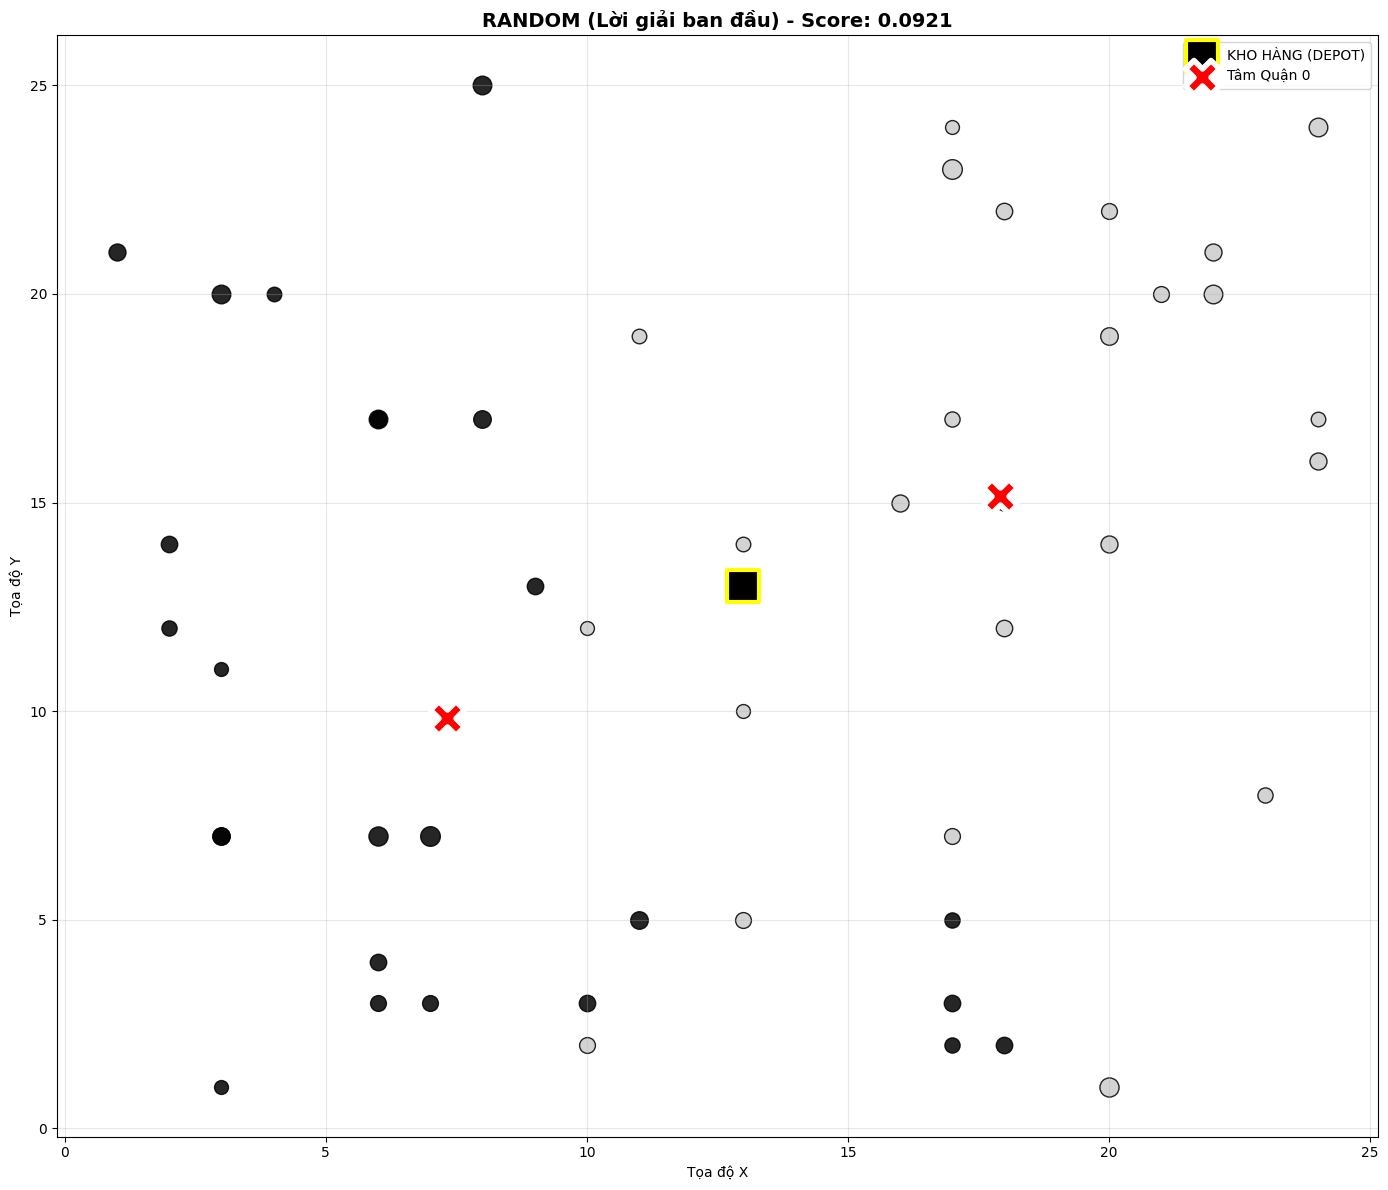

In [165]:
print_strategic_plan(initial_solution, areas, initial_assignments, "RANDOM (Lời giải ban đầu)")

# Vẽ biểu đồ cho lời giải ban đầu
print("\nTrực quan hóa lời giải ban đầu...")
plot_solution(initial_solution, areas, 
             f"RANDOM (Lời giải ban đầu) - Score: {initial_score:.4f}")


### Local Search với 1 phần tử


THUẬT TOÁN 1: LOCAL SEARCH
 Quận 0: Tổng quãng đường=24.53km, Thời gian di chuyển=0.49h
 Quận 0: 0.49 (di chuyển) + 0.75 (nạp lại) + 3.86 (phục vụ) = 5.10h
 Quận 1: Tổng quãng đường=20.07km, Thời gian di chuyển=0.40h
 Quận 1: 0.40 (di chuyển) + 0.50 (nạp lại) + 3.49 (phục vụ) = 4.39h
 Quận 0: Tổng quãng đường=24.21km, Thời gian di chuyển=0.48h
 Quận 0: 0.48 (di chuyển) + 0.75 (nạp lại) + 3.75 (phục vụ) = 4.98h
 Quận 1: Tổng quãng đường=21.28km, Thời gian di chuyển=0.43h
 Quận 1: 0.43 (di chuyển) + 0.50 (nạp lại) + 3.60 (phục vụ) = 4.53h
 Quận 0: Tổng quãng đường=24.53km, Thời gian di chuyển=0.49h
 Quận 0: 0.49 (di chuyển) + 0.75 (nạp lại) + 3.86 (phục vụ) = 5.10h
 Quận 1: Tổng quãng đường=20.07km, Thời gian di chuyển=0.40h
 Quận 1: 0.40 (di chuyển) + 0.50 (nạp lại) + 3.49 (phục vụ) = 4.39h
 Quận 0: Tổng quãng đường=23.03km, Thời gian di chuyển=0.46h
 Quận 0: 0.46 (di chuyển) + 0.75 (nạp lại) + 3.58 (phục vụ) = 4.79h
 Quận 1: Tổng quãng đường=22.60km, Thời gian di chuyển=0.45h
 Quận 1:

C:\Users\Admin\AppData\Local\Temp\ipykernel_13540\4021880790.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', NUM_DISTRICTS)


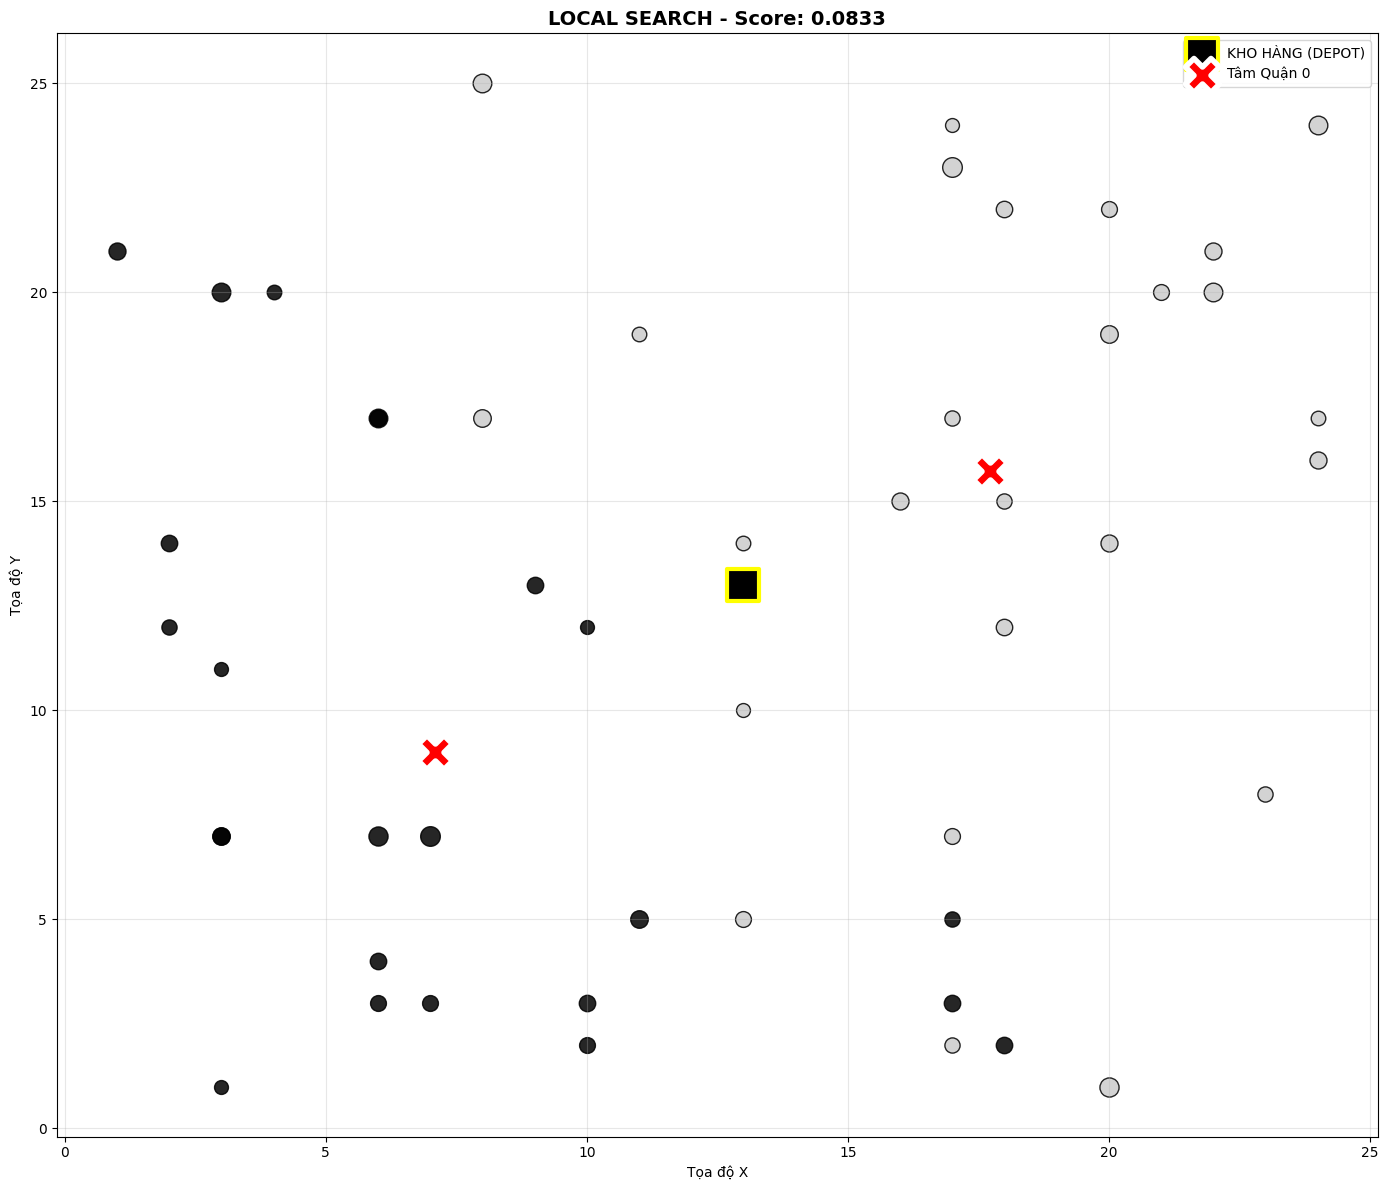

In [166]:
print("\n" + "="*80)
print("THUẬT TOÁN 1: LOCAL SEARCH")
print("="*80)

ls_solution, ls_score = local_search(initial_solution, areas)

print(f"\nKết quả Local Search:")
print(f" → Điểm tốt nhất: {ls_score:.4f}")
print(f" → Cải thiện: {((initial_score - ls_score) / initial_score * 100):.1f}%")

ls_assignments, ls_stats = assign_resources_to_districts(ls_solution, areas)

print("\nTrực quan hóa Local Search...")
plot_solution(ls_solution, areas, 
             f"LOCAL SEARCH - Score: {ls_score:.4f}")


In [167]:
print_strategic_plan(ls_solution, areas, ls_assignments, "LOCAL SEARCH")



 KẾ HOẠCH CHIẾN THUẬT - Thuật toán: LOCAL SEARCH
 Quận 0: Tổng quãng đường=22.36km, Thời gian di chuyển=0.45h
 Quận 0: 0.45 (di chuyển) + 0.75 (nạp lại) + 3.62 (phục vụ) = 4.82h
 Quận 1: Tổng quãng đường=21.35km, Thời gian di chuyển=0.43h
 Quận 1: 0.43 (di chuyển) + 0.50 (nạp lại) + 3.73 (phục vụ) = 4.66h

BẢNG TỔNG QUAN PHÂN CÔNG
Quận   Tài xế           Loại                 Xe               Khu vực    Tổng TG/Time     Bưu kiện/h     Trọng lượng        Chuyến   Tỷ lệ sử dụng  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
0      2                Full-time            Xe máy to        24         4.82/8.0h        70.4 pcs/h     60.8/20 kg         4x       60.2%          
1      1                Full-time            Xe máy to        26         4.66/8.0h        78.6 pcs/h     57.3/20 kg         3x       58.2%          
----------------------------------------------------------


THUẬT TOÁN 2: VNS (Variable Neighborhood Search)
 Quận 0: Tổng quãng đường=24.53km, Thời gian di chuyển=0.49h
 Quận 0: 0.49 (di chuyển) + 0.75 (nạp lại) + 3.86 (phục vụ) = 5.10h
 Quận 1: Tổng quãng đường=20.07km, Thời gian di chuyển=0.40h
 Quận 1: 0.40 (di chuyển) + 0.50 (nạp lại) + 3.49 (phục vụ) = 4.39h
 Quận 0: Tổng quãng đường=10.12km, Thời gian di chuyển=0.20h
 Quận 0: 0.20 (di chuyển) + 0.25 (nạp lại) + 1.90 (phục vụ) = 2.35h
 Quận 1: Tổng quãng đường=36.08km, Thời gian di chuyển=0.72h
 Quận 1: 0.72 (di chuyển) + 1.00 (nạp lại) + 5.45 (phục vụ) = 7.17h
 Quận 0: Tổng quãng đường=9.71km, Thời gian di chuyển=0.19h
 Quận 0: 0.19 (di chuyển) + 0.25 (nạp lại) + 1.79 (phục vụ) = 2.23h
 Quận 1: Tổng quãng đường=36.95km, Thời gian di chuyển=0.74h
 Quận 1: 0.74 (di chuyển) + 1.00 (nạp lại) + 5.56 (phục vụ) = 7.30h
 Quận 0: Tổng quãng đường=11.41km, Thời gian di chuyển=0.23h
 Quận 0: 0.23 (di chuyển) + 0.25 (nạp lại) + 2.07 (phục vụ) = 2.55h
 Quận 1: Tổng quãng đường=34.88km, Thời gian di 

 Quận 0: Tổng quãng đường=28.46km, Thời gian di chuyển=0.57h
 Quận 0: 0.57 (di chuyển) + 0.75 (nạp lại) + 4.29 (phục vụ) = 5.61h
 Quận 1: Tổng quãng đường=20.66km, Thời gian di chuyển=0.41h
 Quận 1: 0.41 (di chuyển) + 0.50 (nạp lại) + 3.06 (phục vụ) = 3.97h
 Quận 0: Tổng quãng đường=28.88km, Thời gian di chuyển=0.58h
 Quận 0: 0.58 (di chuyển) + 0.75 (nạp lại) + 4.31 (phục vụ) = 5.64h
 Quận 1: Tổng quãng đường=20.64km, Thời gian di chuyển=0.41h
 Quận 1: 0.41 (di chuyển) + 0.50 (nạp lại) + 3.04 (phục vụ) = 3.95h
 Quận 0: Tổng quãng đường=28.92km, Thời gian di chuyển=0.58h
 Quận 0: 0.58 (di chuyển) + 0.75 (nạp lại) + 4.29 (phục vụ) = 5.62h
 Quận 1: Tổng quãng đường=20.48km, Thời gian di chuyển=0.41h
 Quận 1: 0.41 (di chuyển) + 0.50 (nạp lại) + 3.06 (phục vụ) = 3.97h
 Quận 0: Tổng quãng đường=28.05km, Thời gian di chuyển=0.56h
 Quận 0: 0.56 (di chuyển) + 0.75 (nạp lại) + 4.33 (phục vụ) = 5.64h
 Quận 1: Tổng quãng đường=21.29km, Thời gian di chuyển=0.43h
 Quận 1: 0.43 (di chuyển) + 0.50 (nạ

C:\Users\Admin\AppData\Local\Temp\ipykernel_13540\4021880790.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', NUM_DISTRICTS)


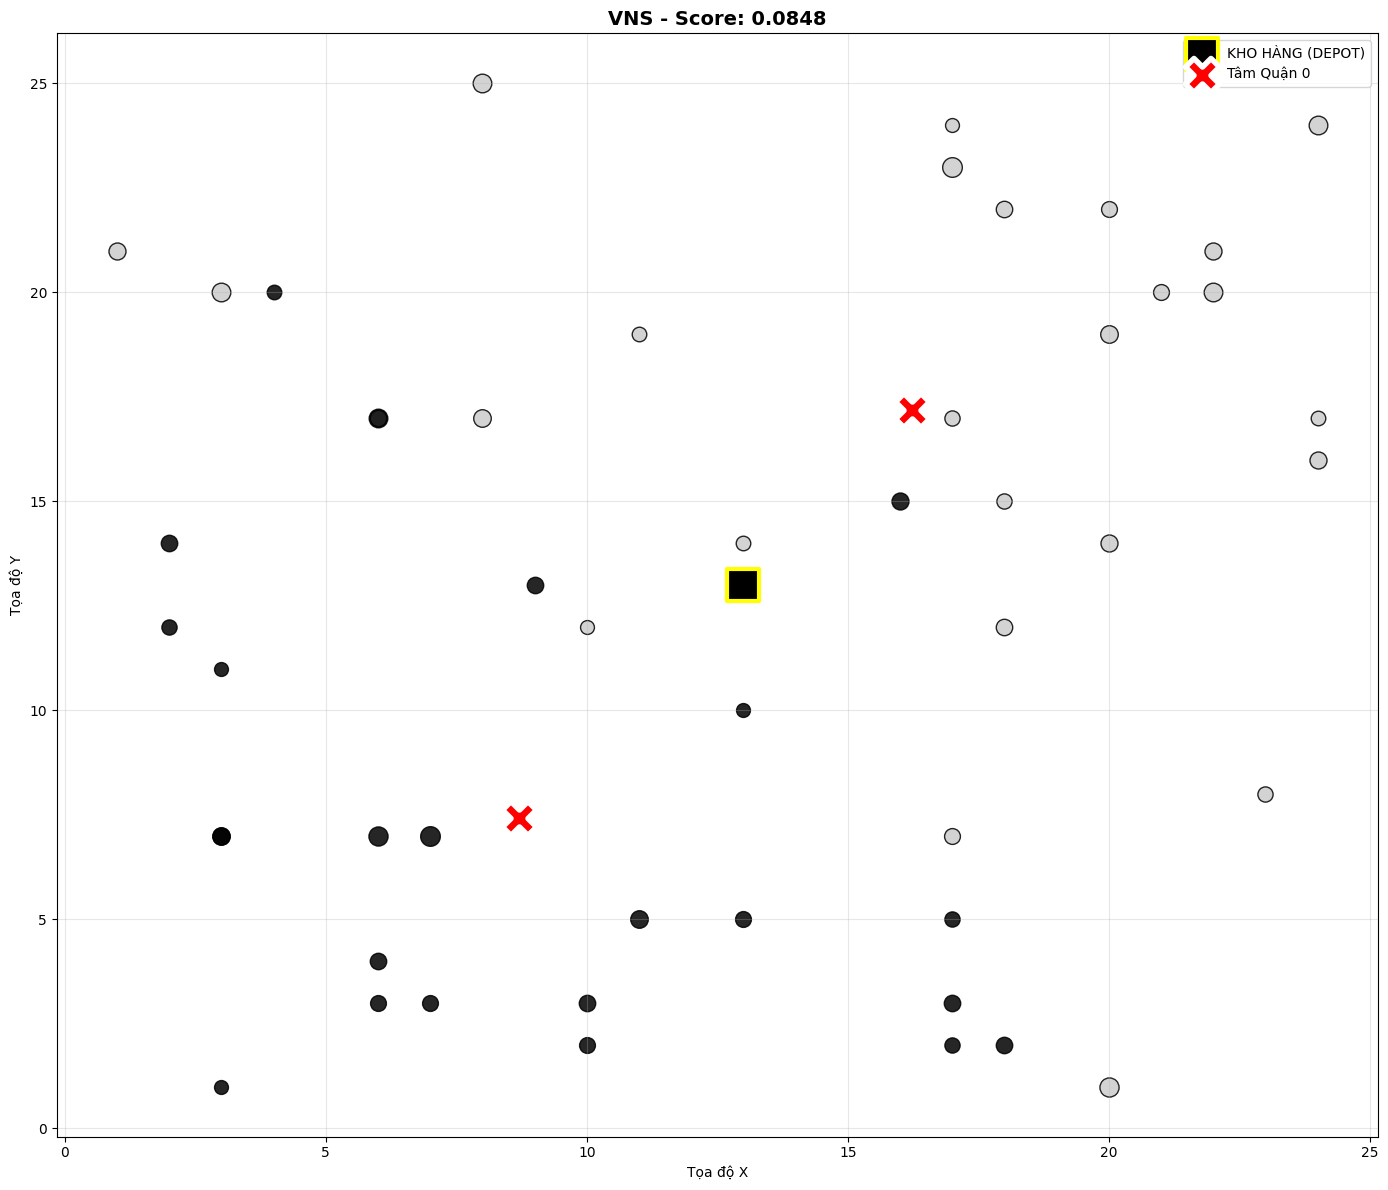

In [168]:
# =============================================================================
# BƯỚC 3: CHẠY VNS
# =============================================================================

print("\n" + "="*80)
print("THUẬT TOÁN 2: VNS (Variable Neighborhood Search)")
print("="*80)

vns_solution, vns_score = vns(initial_solution, areas)

print(f"\nKết quả VNS:")
print(f" → Điểm cuối: {vns_score:.4f}")
print(f" → Cải thiện: {((initial_score - vns_score) / initial_score * 100):.1f}%")

vns_assignments, vns_stats = assign_resources_to_districts(vns_solution, areas)

print("\nTrực quan hóa VNS...")
plot_solution(vns_solution, areas, 
             f"VNS - Score: {vns_score:.4f}")


In [169]:
print_strategic_plan(vns_solution, areas, vns_assignments, "VNS")



 KẾ HOẠCH CHIẾN THUẬT - Thuật toán: VNS
 Quận 0: Tổng quãng đường=21.40km, Thời gian di chuyển=0.43h
 Quận 0: 0.43 (di chuyển) + 0.75 (nạp lại) + 3.60 (phục vụ) = 4.78h
 Quận 1: Tổng quãng đường=22.89km, Thời gian di chuyển=0.46h
 Quận 1: 0.46 (di chuyển) + 0.50 (nạp lại) + 3.75 (phục vụ) = 4.71h

BẢNG TỔNG QUAN PHÂN CÔNG
Quận   Tài xế           Loại                 Xe               Khu vực    Tổng TG/Time     Bưu kiện/h     Trọng lượng        Chuyến   Tỷ lệ sử dụng  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
0      2                Full-time            Xe máy to        24         4.78/8.0h        69.5 pcs/h     62.3/20 kg         4x       59.7%          
1      1                Full-time            Xe máy to        26         4.71/8.0h        79.2 pcs/h     55.8/20 kg         3x       58.8%          
-------------------------------------------------------------------

### Local Search với Multi-Swap

In [170]:
### 3A-2. Local Search với Multi-Swap - Phiên bản mạnh mẽ ###
def local_search_multi_swap(initial_solution, areas, use_contiguity=True, swap_size=2):

    current_solution = list(initial_solution)
    current_score = calculate_objective_function_with_resources(current_solution, areas)
    
    initial_score = current_score
    best_solution = list(current_solution)
    best_score = current_score
    
    # Xây dựng đồ thị lân cận
    neighbor_graph = None
    if use_contiguity:
        neighbor_graph = build_neighbor_graph(areas)
    
    improved = True
    iteration = 0
    max_iterations = 50
    
    while improved and iteration < max_iterations:
        improved = False
        iteration += 1
        
        # CHIẾN LƯỢC 1: Di chuyển đơn lẻ (fast exploration)
        for _ in range(200): 
            area_idx = random.randint(0, len(areas) - 1)
            current_district = current_solution[area_idx]
            new_district = random.randint(0, NUM_DISTRICTS - 1)
            
            if new_district == current_district:
                continue
            
            neighbor_solution = list(current_solution)
            neighbor_solution[area_idx] = new_district
            
            # Kiểm tra contiguity
            if use_contiguity and neighbor_graph:
                if not is_contiguous(neighbor_solution, neighbor_graph, current_district):
                    continue
                if not is_contiguous(neighbor_solution, neighbor_graph, new_district):
                    continue
            
            neighbor_score = calculate_objective_function_with_resources(neighbor_solution, areas)
            
            if neighbor_score < current_score:
                current_solution = neighbor_solution
                current_score = neighbor_score
                improved = True
                break
        
        if improved:
            if current_score < best_score:
                best_solution = list(current_solution)
                best_score = current_score
            continue
        
        # CHIẾN LƯỢC 2: Swap ngẫu nhiên giữa các cặp quận
        district_pairs = [(a, b) for a in range(NUM_DISTRICTS) for b in range(a + 1, NUM_DISTRICTS)]
        random.shuffle(district_pairs)
        
        for district_a, district_b in district_pairs[:200]: 
            areas_a = [i for i, d in enumerate(current_solution) if d == district_a]
            areas_b = [i for i, d in enumerate(current_solution) if d == district_b]
            
            if len(areas_a) == 0 or len(areas_b) == 0:
                continue
            
            for _ in range(3):
                sample_size = min(swap_size, len(areas_a), len(areas_b))
                sample_a = random.sample(areas_a, sample_size)
                sample_b = random.sample(areas_b, sample_size)
                
                neighbor_solution = list(current_solution)
                for idx in sample_a:
                    neighbor_solution[idx] = district_b
                for idx in sample_b:
                    neighbor_solution[idx] = district_a
                
                if use_contiguity and neighbor_graph:
                    if not is_contiguous(neighbor_solution, neighbor_graph, district_a):
                        continue
                    if not is_contiguous(neighbor_solution, neighbor_graph, district_b):
                        continue
                
                neighbor_score = calculate_objective_function_with_resources(neighbor_solution, areas)
                
                if neighbor_score < current_score:
                    current_solution = neighbor_solution
                    current_score = neighbor_score
                    improved = True
                    break
            
            if improved:
                break
        
        if current_score < best_score:
            best_solution = list(current_solution)
            best_score = current_score
    
    # Sửa contiguity cuối cùng
    if use_contiguity and neighbor_graph:
        repaired_solution = repair_contiguous(list(best_solution), neighbor_graph)
        repaired_score = calculate_objective_function_with_resources(repaired_solution, areas)
        
        if repaired_score <= best_score:
            best_solution = repaired_solution
            best_score = repaired_score
    
    # Đảm bảo không tệ hơn initial
    if best_score > initial_score:
        return list(initial_solution), initial_score
    
    return best_solution, best_score

In [171]:
### 3B. Variable Neighborhood Search (VNS) với Contiguity ###
def shake_2(solution, k):
    new_solution = list(solution)
    
    # Lặp k lần để thực hiện shake mạnh hơn
    for _ in range(k):
        # Chọn ngẫu nhiên 1 quận để shake
        district_to_shake = random.randint(0, NUM_DISTRICTS - 1)
        
        # Lấy danh sách các khu vực thuộc quận này
        areas_in_district = [i for i, d in enumerate(new_solution) if d == district_to_shake]
        
        if len(areas_in_district) == 0:
            continue
        
        # Chuyển 20% số khu vực của quận này (tối thiểu 1 khu vực)
        num_areas_to_move = max(1, int(len(areas_in_district) * 0.20))
        
        # Chọn ngẫu nhiên các khu vực để di chuyển
        areas_to_move = random.sample(areas_in_district, min(num_areas_to_move, len(areas_in_district)))
        
        # Di chuyển các khu vực sang quận khác
        for area_idx in areas_to_move:
            # Chọn quận đích khác với quận hiện tại
            new_district = random.randint(0, NUM_DISTRICTS - 1)
            while new_district == district_to_shake and NUM_DISTRICTS > 1:
                new_district = random.randint(0, NUM_DISTRICTS - 1)
            new_solution[area_idx] = new_district
    
    return new_solution

def vns_2(initial_solution, areas, max_iter=4, k_max=4, use_contiguity=True):

    best_solution = list(initial_solution)
    best_score = calculate_objective_function_with_resources(best_solution, areas)
    
    # Xây dựng đồ thị lân cận
    neighbor_graph = None
    if use_contiguity:
        neighbor_graph = build_neighbor_graph(areas)

    for iteration in range(max_iter):
        k = 1
        while k <= k_max:
            # Shake với cường độ k
            shaken_solution = shake_2(best_solution, k)
            
            # Sửa contiguity cho solution sau khi shake
            if use_contiguity and neighbor_graph:
                shaken_solution = repair_contiguous(shaken_solution, neighbor_graph)
            
            # Local search để cải thiện
            improved_solution, improved_score = local_search_multi_swap(shaken_solution, areas, use_contiguity)
            # Nếu tìm được cải thiện
            if improved_score < best_score:
                best_solution = improved_solution
                best_score = improved_score
                print(f"VNS_2 Iter {iteration}, k={k}: New best = {best_score:.4f}")
                k = 1  # Reset về neighborhood nhỏ nhất
            else:
                k += 1  # Thử neighborhood lớn hơn
                
    return best_solution, best_score

print("Đã cập nhật VNS_2 với logic chuẩn")

Đã cập nhật VNS_2 với logic chuẩn



THUẬT TOÁN 1: LOCAL SEARCH 2
 Quận 0: Tổng quãng đường=24.53km, Thời gian di chuyển=0.49h
 Quận 0: 0.49 (di chuyển) + 0.75 (nạp lại) + 3.86 (phục vụ) = 5.10h
 Quận 1: Tổng quãng đường=20.07km, Thời gian di chuyển=0.40h
 Quận 1: 0.40 (di chuyển) + 0.50 (nạp lại) + 3.49 (phục vụ) = 4.39h
 Quận 0: Tổng quãng đường=25.00km, Thời gian di chuyển=0.50h
 Quận 0: 0.50 (di chuyển) + 0.75 (nạp lại) + 4.04 (phục vụ) = 5.29h
 Quận 1: Tổng quãng đường=19.43km, Thời gian di chuyển=0.39h
 Quận 1: 0.39 (di chuyển) + 0.50 (nạp lại) + 3.31 (phục vụ) = 4.20h
 Quận 0: Tổng quãng đường=25.34km, Thời gian di chuyển=0.51h
 Quận 0: 0.51 (di chuyển) + 0.75 (nạp lại) + 3.97 (phục vụ) = 5.23h
 Quận 1: Tổng quãng đường=18.68km, Thời gian di chuyển=0.37h
 Quận 1: 0.37 (di chuyển) + 0.50 (nạp lại) + 3.38 (phục vụ) = 4.25h
 Quận 0: Tổng quãng đường=23.55km, Thời gian di chuyển=0.47h
 Quận 0: 0.47 (di chuyển) + 0.75 (nạp lại) + 3.75 (phục vụ) = 4.97h
 Quận 1: Tổng quãng đường=21.08km, Thời gian di chuyển=0.42h
 Quận 

C:\Users\Admin\AppData\Local\Temp\ipykernel_13540\4021880790.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', NUM_DISTRICTS)


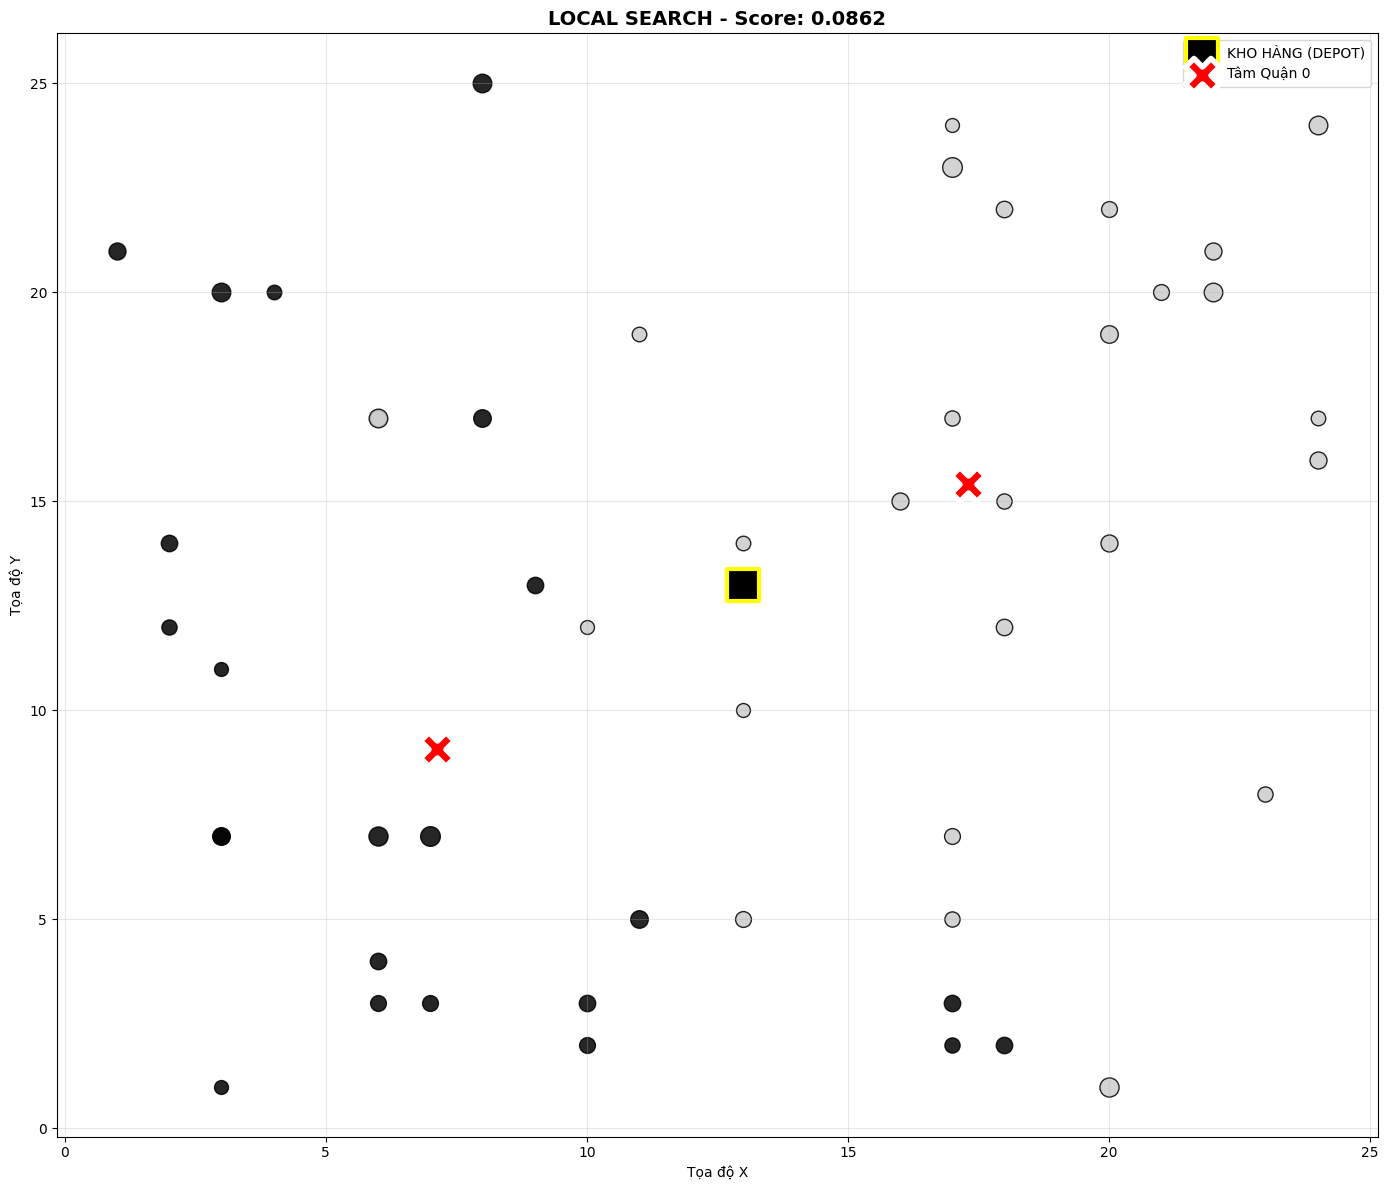

In [172]:
print("\n" + "="*80)
print("THUẬT TOÁN 1: LOCAL SEARCH 2")
print("="*80)

ls_solution_2, ls_score_2 = local_search_multi_swap(initial_solution, areas)

print(f"\nKết quả Local Search:")
print(f" → Điểm tốt nhất: {ls_score_2:.4f}")
print(f" → Cải thiện: {((initial_score - ls_score_2) / initial_score * 100):.1f}%")

ls_assignments_2, ls_stats_2 = assign_resources_to_districts(ls_solution_2, areas)

print("\nTrực quan hóa Local Search...")
plot_solution(ls_solution_2, areas, 
             f"LOCAL SEARCH - Score: {ls_score_2:.4f}")

In [173]:
print_strategic_plan(ls_solution_2, areas, ls_assignments_2, "LOCAL SEARCH 2")


 KẾ HOẠCH CHIẾN THUẬT - Thuật toán: LOCAL SEARCH 2
 Quận 0: Tổng quãng đường=21.45km, Thời gian di chuyển=0.43h
 Quận 0: 0.43 (di chuyển) + 0.50 (nạp lại) + 3.59 (phục vụ) = 4.52h
 Quận 1: Tổng quãng đường=21.73km, Thời gian di chuyển=0.43h
 Quận 1: 0.43 (di chuyển) + 0.50 (nạp lại) + 3.76 (phục vụ) = 4.69h

BẢNG TỔNG QUAN PHÂN CÔNG
Quận   Tài xế           Loại                 Xe               Khu vực    Tổng TG/Time     Bưu kiện/h     Trọng lượng        Chuyến   Tỷ lệ sử dụng  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
0      2                Full-time            Xe máy to        23         4.52/8.0h        73.2 pcs/h     59.7/20 kg         3x       56.5%          
1      1                Full-time            Xe máy to        27         4.69/8.0h        79.7 pcs/h     58.5/20 kg         3x       58.7%          
--------------------------------------------------------


THUẬT TOÁN 2: VNS (Variable Neighborhood Search)
 Quận 0: Tổng quãng đường=24.53km, Thời gian di chuyển=0.49h
 Quận 0: 0.49 (di chuyển) + 0.75 (nạp lại) + 3.86 (phục vụ) = 5.10h
 Quận 1: Tổng quãng đường=20.07km, Thời gian di chuyển=0.40h
 Quận 1: 0.40 (di chuyển) + 0.50 (nạp lại) + 3.49 (phục vụ) = 4.39h
 Quận 0: Tổng quãng đường=18.63km, Thời gian di chuyển=0.37h
 Quận 0: 0.37 (di chuyển) + 0.50 (nạp lại) + 3.21 (phục vụ) = 4.08h
 Quận 1: Tổng quãng đường=26.37km, Thời gian di chuyển=0.53h
 Quận 1: 0.53 (di chuyển) + 0.50 (nạp lại) + 4.14 (phục vụ) = 5.17h
 Quận 0: Tổng quãng đường=17.49km, Thời gian di chuyển=0.35h
 Quận 0: 0.35 (di chuyển) + 0.50 (nạp lại) + 3.04 (phục vụ) = 3.89h
 Quận 1: Tổng quãng đường=28.85km, Thời gian di chuyển=0.58h
 Quận 1: 0.58 (di chuyển) + 0.75 (nạp lại) + 4.31 (phục vụ) = 5.64h
 Quận 0: Tổng quãng đường=19.15km, Thời gian di chuyển=0.38h
 Quận 0: 0.38 (di chuyển) + 0.50 (nạp lại) + 3.39 (phục vụ) = 4.27h
 Quận 1: Tổng quãng đường=25.82km, Thời gian di

C:\Users\Admin\AppData\Local\Temp\ipykernel_13540\4021880790.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', NUM_DISTRICTS)


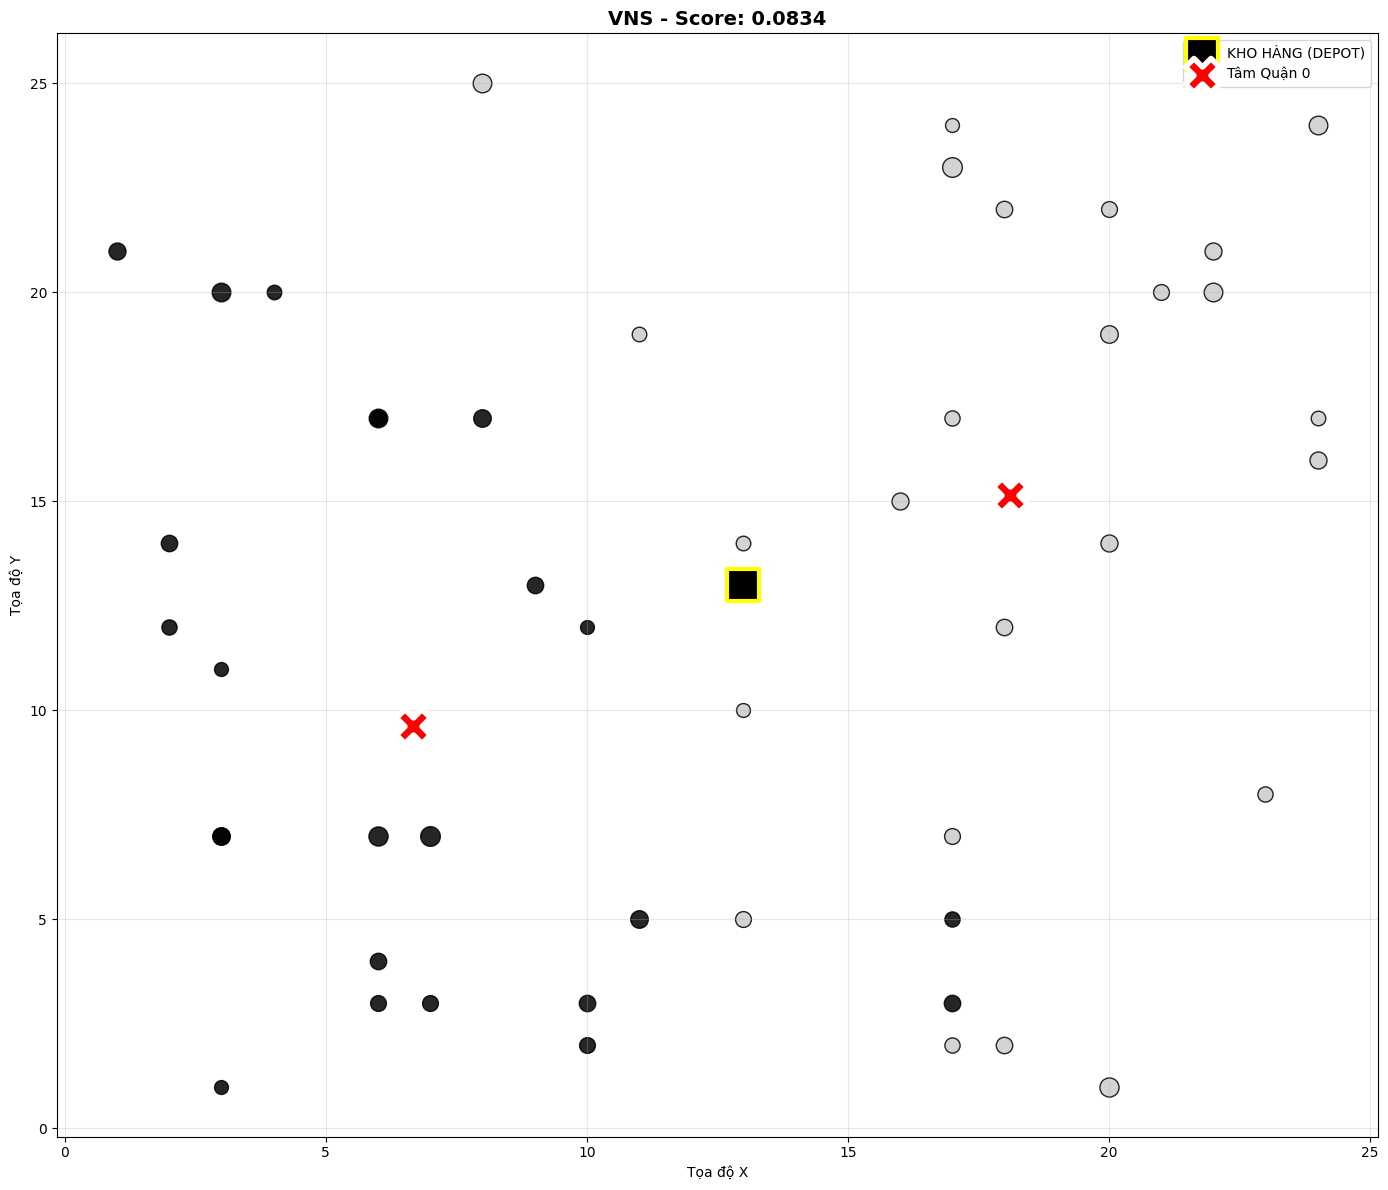

In [174]:
# =============================================================================
# BƯỚC 3: CHẠY VNS
# =============================================================================

print("\n" + "="*80)
print("THUẬT TOÁN 2: VNS (Variable Neighborhood Search)")
print("="*80)

vns_solution_2, vns_score_2 = vns_2(initial_solution, areas)

print(f"\nKết quả VNS:")
print(f" → Điểm cuối: {vns_score_2:.4f}")
print(f" → Cải thiện: {((initial_score - vns_score_2) / initial_score * 100):.1f}%")

vns_assignments_2, vns_stats_2 = assign_resources_to_districts(vns_solution_2, areas)

print("\nTrực quan hóa VNS...")
plot_solution(vns_solution_2, areas, 
             f"VNS - Score: {vns_score_2:.4f}")


In [175]:
print_strategic_plan(vns_solution_2, areas, vns_assignments_2, "VNS")


 KẾ HOẠCH CHIẾN THUẬT - Thuật toán: VNS
 Quận 0: Tổng quãng đường=21.91km, Thời gian di chuyển=0.44h
 Quận 0: 0.44 (di chuyển) + 0.75 (nạp lại) + 3.66 (phục vụ) = 4.85h
 Quận 1: Tổng quãng đường=21.79km, Thời gian di chuyển=0.44h
 Quận 1: 0.44 (di chuyển) + 0.50 (nạp lại) + 3.69 (phục vụ) = 4.63h

BẢNG TỔNG QUAN PHÂN CÔNG
Quận   Tài xế           Loại                 Xe               Khu vực    Tổng TG/Time     Bưu kiện/h     Trọng lượng        Chuyến   Tỷ lệ sử dụng  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
0      2                Full-time            Xe máy to        24         4.85/8.0h        70.3 pcs/h     61.6/20 kg         4x       60.6%          
1      1                Full-time            Xe máy to        26         4.63/8.0h        78.7 pcs/h     56.5/20 kg         3x       57.8%          
-------------------------------------------------------------------

### So sánh kết quả

In [176]:
# =============================================================================
# BƯỚC 5: SO SÁNH KẾT QUẢ
# =============================================================================

print("\n" + "="*80)
print(" SO SÁNH KẾT QUẢ 4 THUẬT TOÁN")
print("="*80)

results = [
    ("Lời giải ban đầu (Random)", initial_score),
    ("Local Search (1 area)", ls_score),
    ("VNS (1 area)", vns_score),
    ("Local Search Multi-Swap", ls_score_2),
    ("VNS Multi-Swap", vns_score_2),
]

print(f"\n{'Thuật toán':<35} {'Điểm số':<15} {'% Cải thiện':<15} {'Xếp hạng'}")
print("-" * 75)

sorted_results = sorted(results[1:], key=lambda x: x[1])  

for idx, (name, score) in enumerate(results):
    if idx == 0:
        print(f"{name:<35} {score:<15.4f} {'N/A':<15} {'N/A'}")
    else:
        improvement = ((initial_score - score) / initial_score * 100)
        rank = next(i+1 for i, (n, s) in enumerate(sorted_results) if n == name)
       
        print(f"{name:<35} {score:<15.4f} {improvement:>6.2f}% {" ":<8} #{rank}")

best_algorithm = sorted_results[0][0]
best_score = sorted_results[0][1]

print("\n" + "="*80)
print(f"THUẬT TOÁN TỐT NHẤT: {best_algorithm} (Score: {best_score:.4f})")
print("="*80)

print("\n📊 SO SÁNH THEO NHÓM:")
print("-" * 80)
print(f"{'Nhóm 1-area swap:':<25} LS={ls_score:.4f}, VNS={vns_score:.4f}")
print(f"{'Nhóm Multi-Swap:':<25} LS={ls_score_2:.4f}, VNS={vns_score_2:.4f}")
print("-" * 80)


 SO SÁNH KẾT QUẢ 4 THUẬT TOÁN

Thuật toán                          Điểm số         % Cải thiện     Xếp hạng
---------------------------------------------------------------------------
Lời giải ban đầu (Random)           0.0921          N/A             N/A
Local Search (1 area)               0.0833            9.54%          #1
VNS (1 area)                        0.0848            7.96%          #3
Local Search Multi-Swap             0.0862            6.44%          #4
VNS Multi-Swap                      0.0834            9.45%          #2

THUẬT TOÁN TỐT NHẤT: Local Search (1 area) (Score: 0.0833)

📊 SO SÁNH THEO NHÓM:
--------------------------------------------------------------------------------
Nhóm 1-area swap:         LS=0.0833, VNS=0.0848
Nhóm Multi-Swap:          LS=0.0862, VNS=0.0834
--------------------------------------------------------------------------------
